## Notebook overview
This notebook builds the basis of the figures in
* Fig. S17
* Fig. S18

These figures were added during revisions (Oct 2020).

From Moses *et al.* (1)


[Moses, D., Yu, F., Ginell, G., Shamoon, N.M., Koenig, P.S., Holehouse, A.S., and Sukenik, S. (2020). Probing the Hidden Sensitivity of Intrinsically Disordered Proteins to their Chemical Environment.](https://www.biorxiv.org/content/10.1101/2020.08.17.252478v1)



In [1]:
import pandas as pd
from analytical_model import energytochi
from analytical_model import chi2nu
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'


RG_PREFACTOR = 0.5

# define the mode to be used (can be 'RE' or 'RG')
R = 'RE' 
if R =='RG':
    PREFACTOR = RG_PREFACTOR
elif R=='RE':
    PREFACTOR = RG_PREFACTOR*np.sqrt(6)
else:
    raise Exception('"R" must be either RG or RE')

    
    ## Read everything in...
all = pd.read_csv('data/chi_all_idrs_all_solutes.csv')


In [2]:
all_solvents = all['sol'].drop_duplicates()
all_idrs = all['idr'].drop_duplicates()
idr_lens = {}
#idr_lens['GS0'] = 0

# define IDR lengths  for downstream analysis
idr_lens['GS8'] = 16
idr_lens['GS16'] = 32
idr_lens['GS24'] = 48
idr_lens['GS32'] = 64
idr_lens['PUMA'] = len('VEEEEWAREIGAQLRRIADDLNAQYERRRQEEQH')
idr_lens['E1A'] = len('MRHIICHGGVITEEMAASLLDQLIEEVLADNLPPPSHFEP')
idr_lens['P53'] = len('MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPD')
idr_lens['Ash1'] = len('GASASSSPSPSTPTKSGKMRSRSSSPVRPKAYTPSPRSPNYHRFALDSPPQSPRRSSNSSITKKGSRRSSGSSPTRHTTRVCV')


### Build dictionary of sequence-to-molecular weights

In [3]:
# example just showing how to retrieve all the raw data 
all.loc[all['sol'] == 'Urea']

,idr,sol,conc,unit,chi,mw (g/mol),mol/kg,monomol/kg
189,GS0,Urea,0.00,M,-0.010669,60.06,0.00,0.00
190,GS0,Urea,0.25,M,-0.004569,60.06,0.25,0.25
191,GS0,Urea,0.50,M,0.014180,60.06,0.50,0.50
192,GS0,Urea,0.75,M,0.024937,60.06,0.75,0.75
193,GS0,Urea,1.00,M,0.027296,60.06,1.00,1.00
...,...,...,...,...,...,...,...,...
1927,P53,Urea,0.50,M,0.082390,60.06,0.50,0.50
1928,P53,Urea,0.75,M,0.105735,60.06,0.75,0.75
1929,P53,Urea,1.00,M,0.139400,60.06,1.00,1.00
1930,P53,Urea,1.25,M,0.171260,60.06,1.25,1.25


## Show names of all the solutes
The cell below bulds and then shows the names and molecular weights. These data must be extracted to build the w/w (%) to molality converter.

Note that we also define the correctly ordered PEG names here which we'll make extensive use of throughout this code.

In [4]:
PEGS = ['EG','PEG200', 'PEG400', 'PEG1500', 'PEG2000', 'PEG4000', 'PEG6000', 'PEG8000', 'PEG10000'] 

solute_mass = {}

for s in all_solvents:
    x = all.loc[all['sol'] == s]
    solute_mass[s] = np.array(x['mw (g/mol)'].drop_duplicates())[0]

print('Solute mass dictionary shown below:')
solute_mass

Solute mass dictionary shown below:


{'Ficoll': 70000.0,
 'D-Sorbitol': 182.17,
 'Glycerol': 92.0,
 'PEG200': 200.0,
 'PEG1500': 1500.0,
 'PEG4000': 4000.0,
 'PEG8000': 8000.0,
 'Sucrose': 342.3,
 'L(+)-Arabinose': 150.13,
 'Dextran': 20000.0,
 'EG': 62.0,
 'PEG400': 400.0,
 'PEG2000': 2000.0,
 'PEG6000': 6000.0,
 'PEG10000': 10000.0,
 'L-Proline': 115.13,
 'Glycine': 75.07,
 'Tricine': 179.17,
 'Sarcosine': 89.09,
 'BetaineH2O': 135.17,
 'L-Tryptophan': 204.23,
 'D-Galactose': 180.16,
 'Trehalose2H2O': 378.33,
 'D-Mannitol': 182.17,
 'Xylitol': 152.15,
 'Meso-Erythritol': 122.0,
 'Myo-Inositol': 180.16,
 'Urea': 60.06,
 'GuHCl': 95.53,
 'NaCl': 58.44,
 'KCl': 74.55}

## Bonus analysis for molality and w/w
Molality is measured in moles per kg and represents the moles of solute per kg of solvent. In dilute solutions molality and molarity are basically the same but as the concentration increases the molality starts to increasingly become larger than the molarity (because the solute itself takes up some volume).

w/w (%) (percentage weight-weight) is the mass of solute vs. the total mass. As a simple, example 5% w/w (%) of PEG200 would be 5 g of PEG and 95 g of water. This is in contrast to w/v (%) (percentage weight volume) which would be the weight of solute in a solution of some volume.

The functions below faciltate converting between molality and weight-weight percentage.

In [5]:
def convert_weight_weight_to_molality(name, ww):
    """
    Function that converts from weight-weight percentage to molality (mol/kg). 
    This specifically
    
    Parameters
    -------------
    name : str
        Name of the solute 
        
    ww : float, int, list or np.ndarray
        One (or more) weight:weight percentages (should be between 0 and 99)
        
    Returns
    --------
    Float or np.ndarray
        Returns one (or more) values corresponding to the appropriate molality
    """
    molw = solute_mass[name]
    
    if isinstance(ww,(list,np.ndarray)):
        ww = np.array(ww)
    

    denom = 100 - ww
    return 1000*((ww/molw)/denom)
    
    
def convert_molality_to_ww(name, molality):
    """
    Converts from one useless unit to another useless unit, because weight-weight
    is just *too easy*.
    
    Parameters
    -------------
    name : str
        Name of the solute 
        
    molality : float, int, list or np.ndarray
        One (or more) weight:weight percentages (should be between 0 and 99)
        
    Returns
    --------
    Float or np.ndarray
        Returns one (or more) values corresponding to the appropriate ww value
    """
    molw = solute_mass[name]
    
    if isinstance(molality,(list,np.ndarray)):
        molality = np.array(molality)
    

    return (100*molw*molality)/ (1000 + molw*molality)
    

## Relationship between molality and weight-volume
The figure below was built just to give some intuition as to why w/w and molality are NOT perfectly linear. We use the convert below to convert from w/w (%) to molality and then approximate molality to molarity to compute the overlap concentration $c^*$.

Ultimately this is because 'moles' as a unit ignores how big something is. So moles/kg (molality) or moles/liter (molarity) suffer from the same issue - 1 mol of GIANT molecules and 1 mol of tiny molecules are the same in terms of the molarity or molality but VERY different in terms of what fraction of the solution is made of solvent/solute (which percentage weight:weight explicitly captures.

Text(0.5, 0, 'w/w (%)')

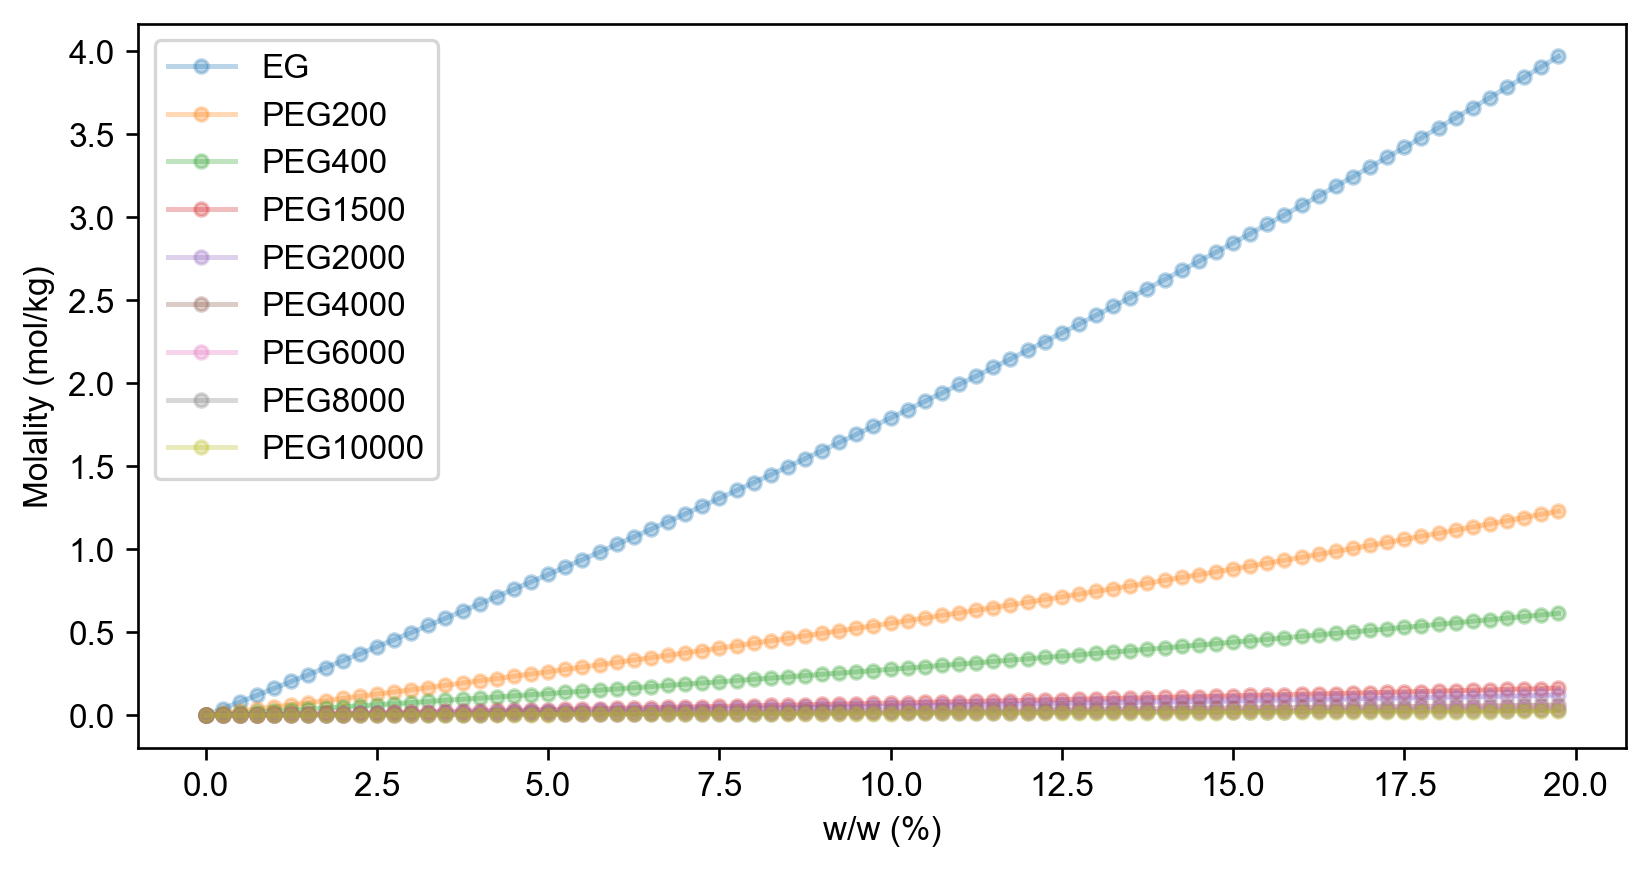

In [6]:
## Draw a simple figure

# set up ww vector
ww_vector = np.arange(0,20,0.25)

# generate figure and plot mapping for each different PEG
figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')
for P in PEGS:
    plt.plot(ww_vector,convert_weight_weight_to_molality(P, ww_vector),'-o',alpha=0.3, markersize=4)
    

plt.legend(PEGS)
plt.ylabel('Molality (mol/kg)')
plt.xlabel('w/w (%)')

In [7]:
def get_conc_chi(idrname, solute):
    """
    Function that returns the concentration, chi value for a given IDR and solute
    as a 2d numpy array
        
    """
    return np.array(all.loc[(all['idr'] == idrname) & (all['sol'] == solute)][['conc','chi']])

def get_molkg_chi(idrname, solute):
    """
    Function that returns the concentration, chi value for a given IDR and solute
    as a 2d numpy array
        
    """
    return np.array(all.loc[(all['idr'] == idrname) & (all['sol'] == solute)][['mol/kg','chi']])
    

## Set up
First pull out of dataframes into dictionaries to make more trivial to play with. Note this code is actually a lot more involved than we need here because it's was taken from one of the other notebooks, but we'll keep it in incase additional overalp concentration questions require other co-solutes.

In [8]:
all_data = {}
all_data_molkg = {}

# for each IDR
for i in all_idrs:
    
    # if this is a new IDR generate empty sub-dictionaries to be populated
    if i not in all_data:
        all_data[i] = {}
        all_data_molkg[i] = {}
        
    # for each solvent
    for s in all_solvents:
        
        # Urea and GuHCl are in molar so have to convert into weight percentage!
        if s in ['Urea','GuHCl','NaCl','KCl']:
            
            # Extract out molal concentration
            molal_conc = get_molkg_chi(i,s).transpose()[0]
            tmp_chi = get_molkg_chi(i,s).transpose()[1]
                                                                                
            # if we're in 
            ww_conc = convert_molality_to_ww(s, get_molkg_chi(i,s).transpose()[0])            
            all_data[i][s] = np.array([ww_conc, tmp_chi]).transpose()
            
        else:
            
            # Otherwise just 
            all_data[i][s] = get_conc_chi(i,s)
            
        all_data_molkg[i][s] = get_molkg_chi(i,s)

# build a list with all solvents EXCEPT NaCl/KCl becuase when we start 
# at 0 NaCl/KCl it's different to zero for other exogenous solutes
all_solvents_no_salt = []
for s in all_solvents:
    if s not in ['NaCl', 'KCl']:            
            all_solvents_no_salt.append(s)
        

### Check spacing is always equal
Cell below is a sanity check to ensure spacing betweens solution points is the same. Note that even if it wasn't we could still make the analysis work, but the even spacing does make things a bit easier to deal with. This should NOT show any WARNING signs but we include it here for completeness!

NOTE that even spacing is true for w:w which within the regime we're in is basically true for molarity and molality as well (see earlier plot).

In [9]:

weight_weight_delta = {}

check_flag = False
for i in all_idrs:
    weight_weight_delta[i] = {}
    for s in all_solvents_no_salt:
        
        #print(s)
        #print(all_data_molkg[i][s][2][0]-all_data_molkg[i][s][1][0])
        # if spacing between points is the same this value is ~0
        summed_secondary_diff = sum(np.diff(np.diff(all_data[i][s].transpose()[0])))       
        

        weight_weight_delta[i][s] = all_data[i][s].transpose()[0][2] - all_data[i][s].transpose()[0][1]
        
        if summed_secondary_diff > 1e-1:
            print('WARNING: %s as %s is not evenly spaced'%(i,s))
            print(all_data_molkg[i][s].transpose()[0])
            check_flag=True
            
if check_flag is False:
    print('Even spacing of solutes checked and valid!')
            



Even spacing of solutes checked and valid!


## Function bank
Set of functions we're going to use

In [10]:
def evaluate(real_chi, proposed_e, L):
    
    total = 0
    for idx in range(len(proposed_e)):
        theory_chi = energytochi(proposed_e[idx], L,PREFACTOR)
        total = total + abs(theory_chi - real_chi[idx])
    return total


def fit_start_energy(start_chi, L):
    best = 10000
    best_start = None
    for start in np.arange(-0.4, 0.4, 0.001):        
        ev = abs(energytochi(start,L, PREFACTOR) - start_chi)
        
        if ev < best:
            best = ev
            best_start = start
            
    return best_start
    
        
def fit_exp_chi_to_energy(chi_val, L, start):
    """
    Function that takes in experimentally measured chi values and determines
    the delta value that maps to the intrinsic concentration multiplier that 
    seperates chi values and reflects the change in chain:chain interaction
    energy that occurs every delta in concentration.
    
    
    Put another way, chi_val is a vector of experimentally measured chi values
    that start in aqeous solvent and then systematically vary as the concentration
    of solute is increased by some constant concentration. The change in chi occurs
    for an IDP of length L, and the behaviour of the protein has a chi value of $start
    under aqeous condtions. This function determines a coefficient "delta" which per
    change in concentration represents the change in chain:chain interaction strength.
    
    Parameters
    ------------------
    chi_vals : list
        List of chi values obtained after systematically titrating the concentration of
        some consolute
        
    L : int
        Length of the IDP (in amino acids)
        
    start : float
        Chi value in aqeous conditions
        
    Returns
    -------------
    tuple
        Returns a tupe of (best_delta, v). Here best_delta is the coefficient that maps
        change in concentration to change in energy for THIS solvent titration and v IS the
        energy values that match to the passed chi values
    """
    
    best = 100000
    best_delta = None
    n_vals = len(chi_val)
    
    for delta in np.arange(-0.02, 0.02, 0.0005):
        
        v = start + np.arange(n_vals)*delta    
        ev = evaluate(chi_val, v, L)
        #print('%1.4f, %1.3f' %(, delta, ev))
        if ev < best:
            #print(delta)
            best = ev
            best_delta = delta

    v = start + np.arange(n_vals)*best_delta
                                    
    return (best_delta, v)


def PEG_RG_from_MW(MW):
    """
    Function that returns the PEG radius of gyration in nanometers (nm) as a function
    of PEG molecular weight. 
    
    Based on equation 2 from Devanand, K., and Selser, J.C. (1991). Asymptotic behavior 
    and long-range interactions in aqueous solutions of poly(ethylene oxide). Macromolecules 
    24, 5943–5947.
    """
    
    return 0.0215*np.power(MW, 0.583)

def overlap_concentration_from_rg(rg):
    """
    rg in nm
    
    c = n/v
    
    n = 1
    v = (4/3)* pi rg^3 
    """
    NA=6.022e23
    vol_m3 = (4/3)*np.pi*np.power(rg/1e9,3)
    vol_l = vol_m3*1000
    
    c = 1/vol_l
    return c/NA


## Set up PEGS 
Here we set up the PEG Rg values and associated overlap concentrations (in MOLAR units, admitedly...) but we're going to make the handwavy assumption that molar and molal overlap concentrations are in the same ballpark.

In [12]:
PEG_RG = {}
PEG_CSTAR = {}
PEG_RG['EG'] = PEG_RG_from_MW(1)
PEG_RG['PEG200'] = PEG_RG_from_MW(200)
PEG_RG['PEG400'] = PEG_RG_from_MW(400)
PEG_RG['PEG1500'] = PEG_RG_from_MW(1500)
PEG_RG['PEG2000'] = PEG_RG_from_MW(2000)
PEG_RG['PEG4000'] = PEG_RG_from_MW(4000)
PEG_RG['PEG6000'] = PEG_RG_from_MW(6000)
PEG_RG['PEG8000'] = PEG_RG_from_MW(8000)
PEG_RG['PEG10000'] = PEG_RG_from_MW(10000)

for i in PEG_RG:
    PEG_CSTAR[i] = overlap_concentration_from_rg(PEG_RG[i])
    

## Protein-specific PEG dependence
This cell generates **Fig. S18**.

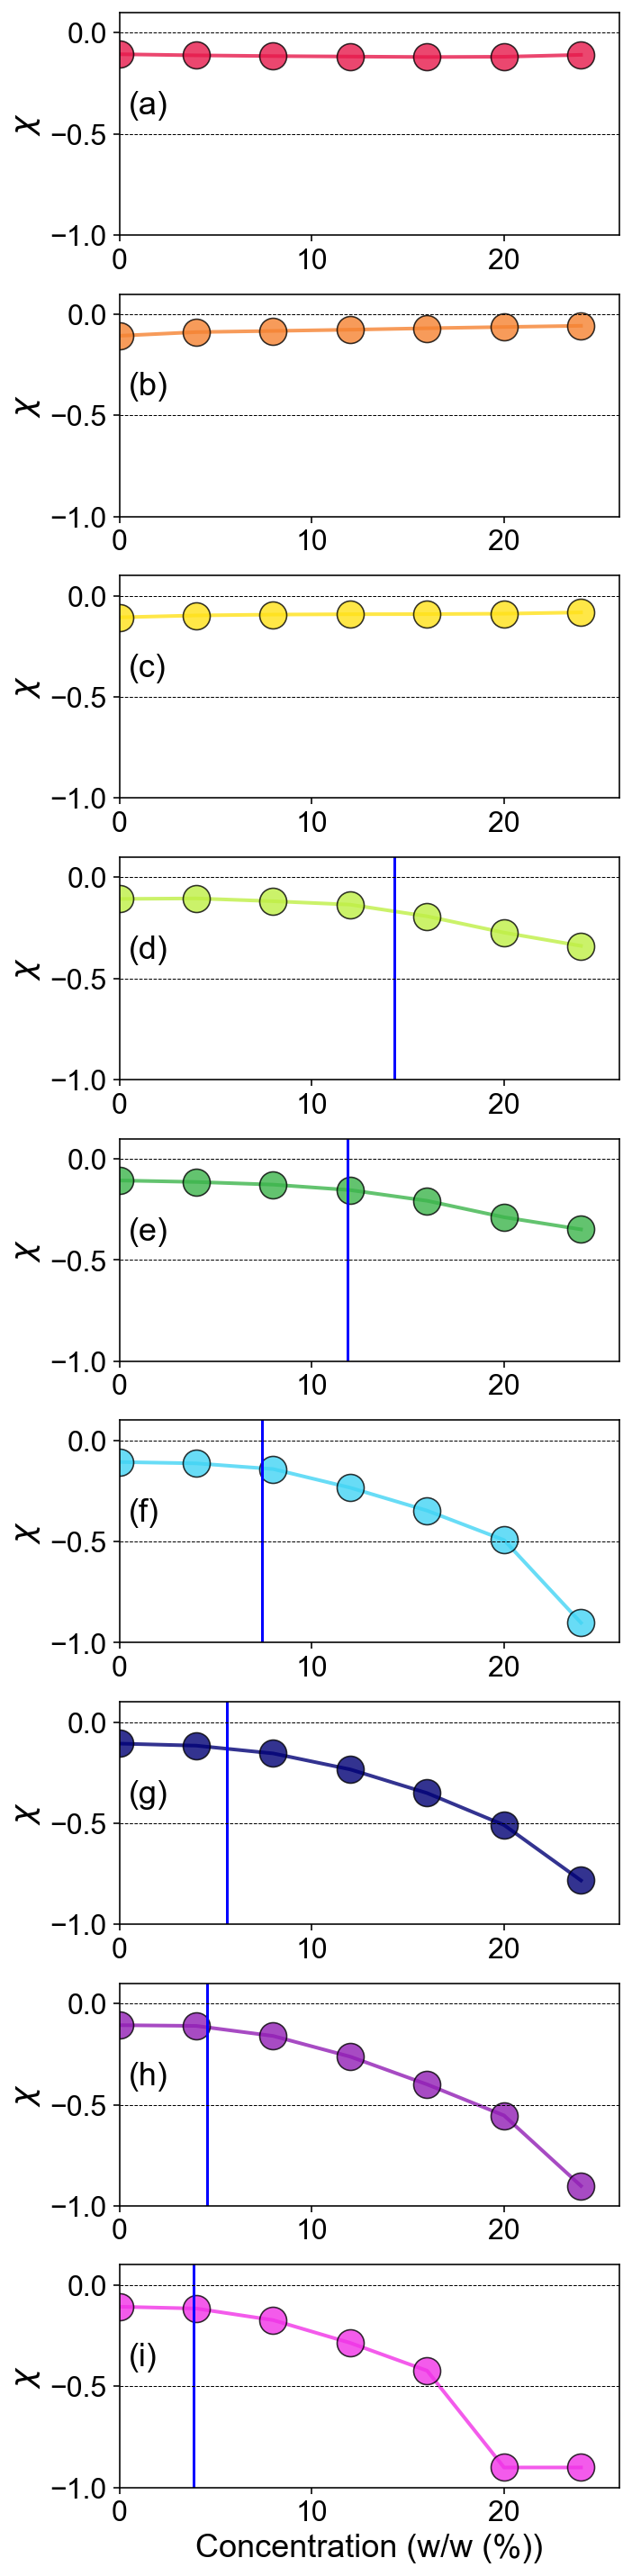

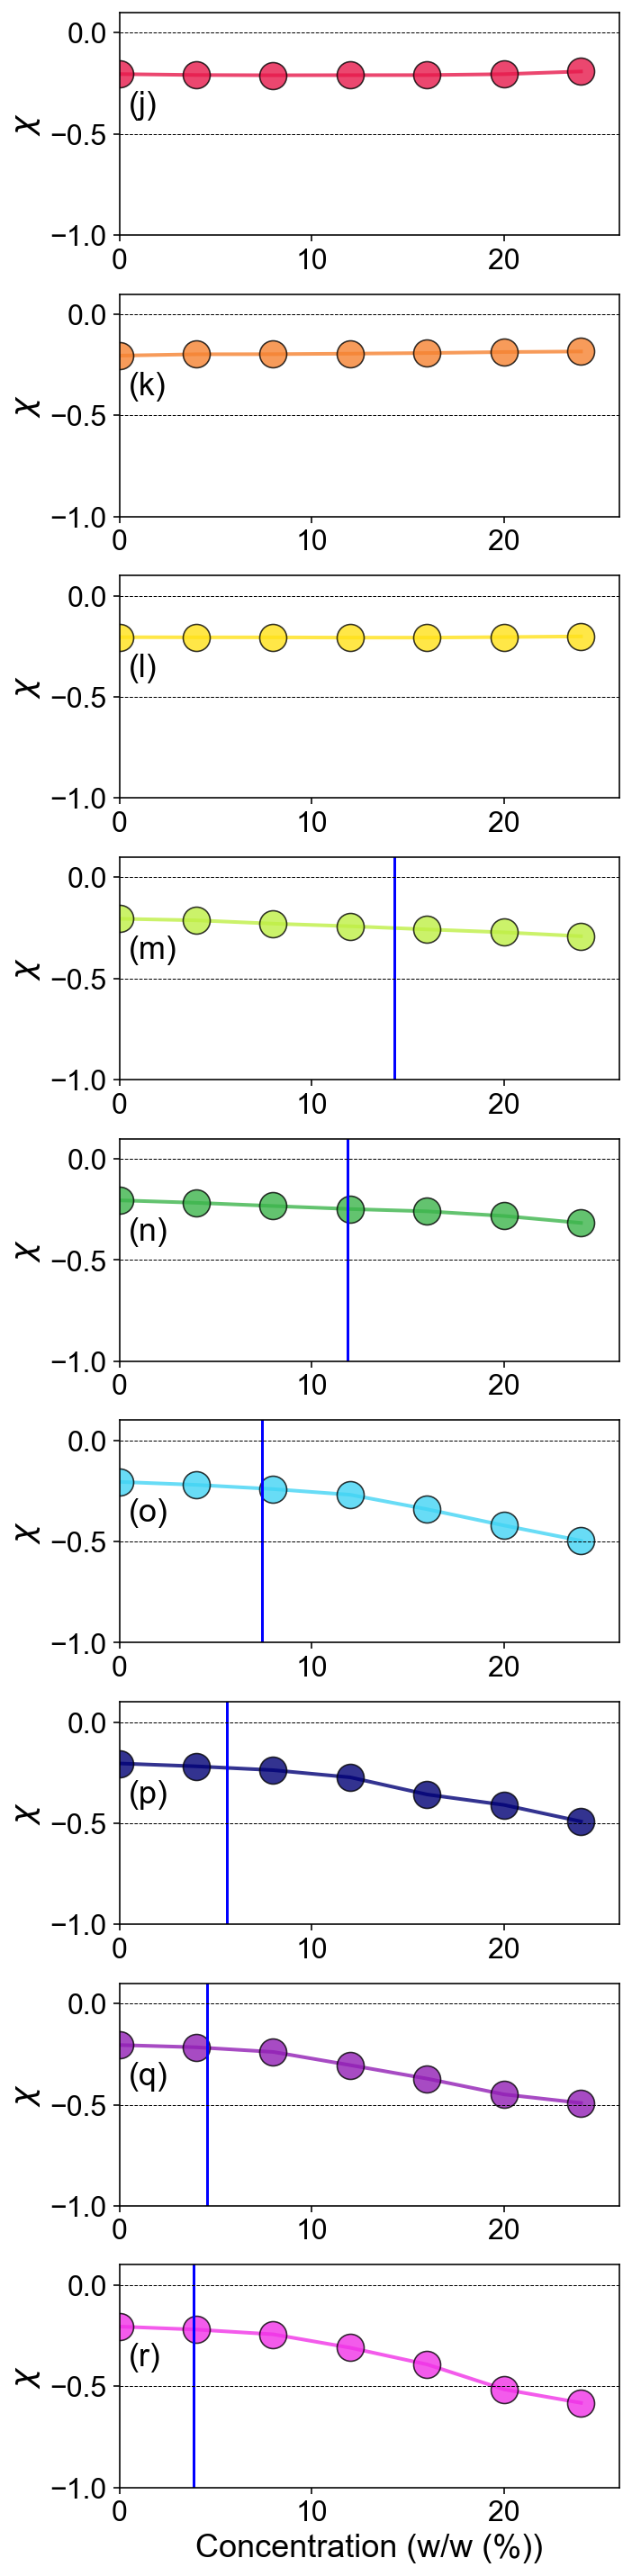

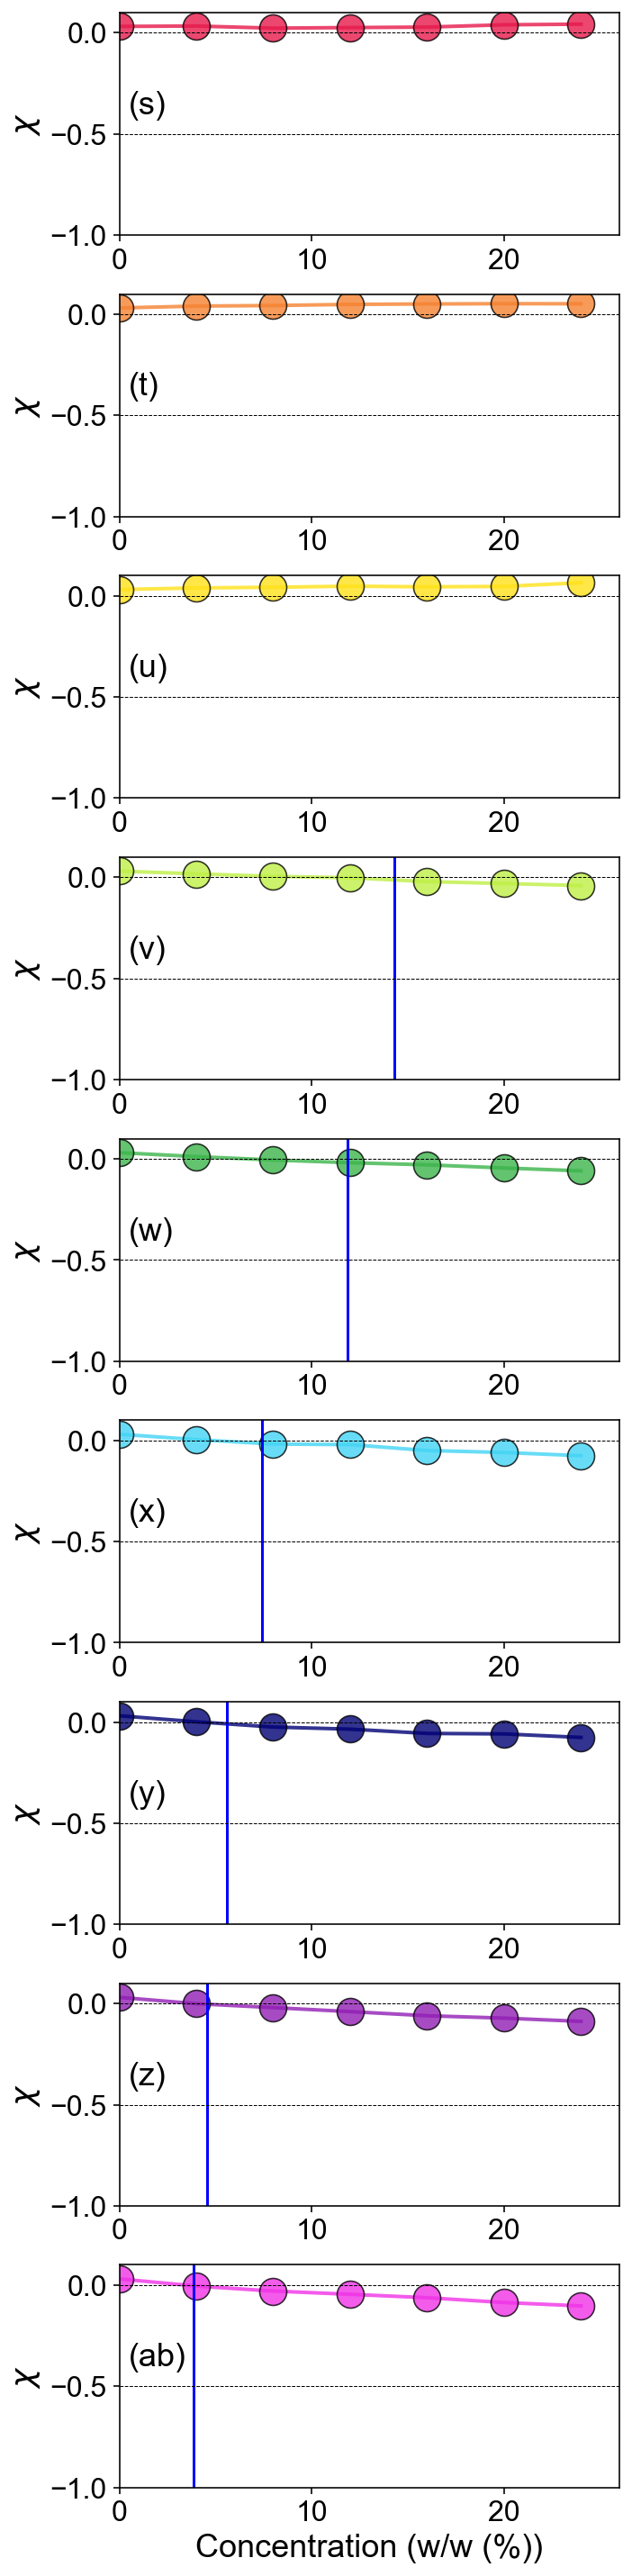

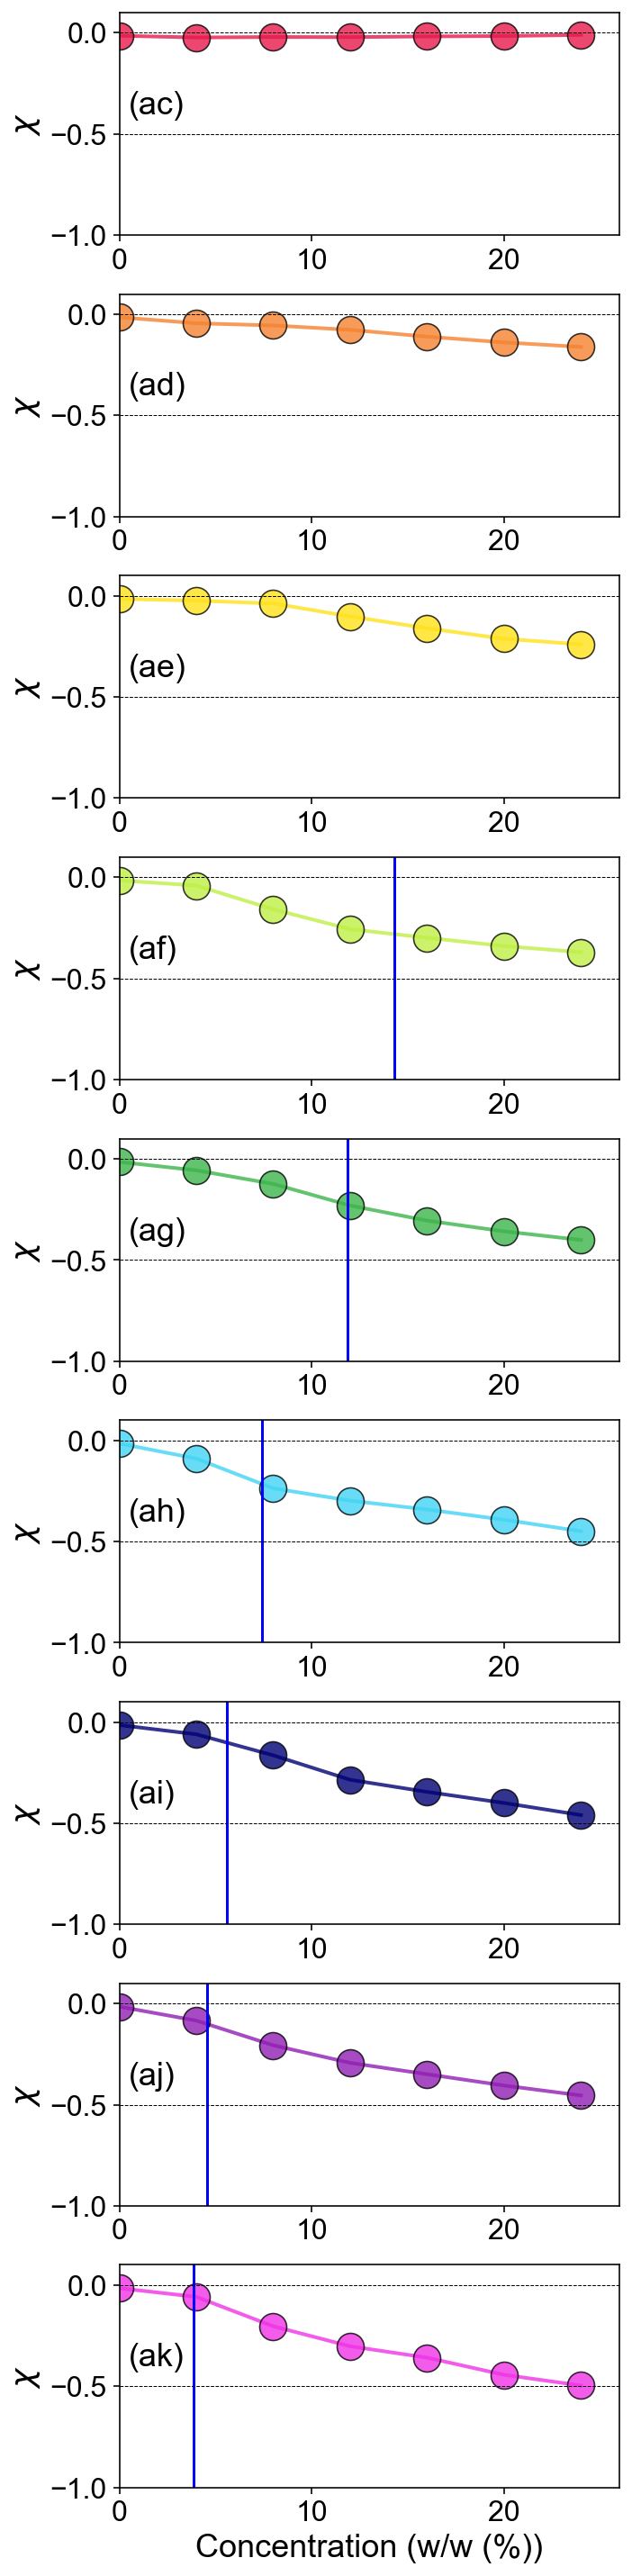

In [13]:

from colour import Color

# flag that sets how big the actual figure is!
scalar = 0.8

# define grouping of solutes
PEGS = ['EG','PEG200', 'PEG400', 'PEG1500', 'PEG2000', 'PEG4000', 'PEG6000', 'PEG8000','PEG10000'] 
ind = np.arange(len(all_solvents_no_salt))


# define colours for each of those groups
COLOR_SETS = [["#FFEDEA", "#CD2200"],
              ["#D3D2D2", "#3B3B3B"],
              ["#A5FBFE", "#06E8F0"],
              ["#CDD1F7", "#061FF0"],
              ["#EDEAAD", "#F0E505"],
              ["#F39BF1", "#F30DEF"]]

ALL_COLORS = ['#e6194B', '#f58231', '#ffe119', '#bfef45', '#3cb44b', '#42d4f4', '#000075', '#911eb4', '#f032e6']

#for protein in idr_lens:

pannel_idx = 0
plot_legend = False
for protein in ['PUMA','E1A','P53','Ash1']:
    

    idx = 0
    fig, axes = plt.subplots(ncols=1, nrows=9, figsize=(5, 20))
    
    pannel = 'abcdefghijklmnopqrstuvwxyz'
    
    for s in PEGS:

        # extract out chi and concentration (in weight/weight %)
        tmp_chi = all_data[protein][s].transpose()[1]
        tmp_conc = all_data[protein][s].transpose()[0]

        # get me the freakin overlap concentration in molar units
        cstar = PEG_CSTAR[s]
        csta_ww = convert_molality_to_ww(s, cstar)

        axes[idx].plot(tmp_conc , tmp_chi,'-o',alpha=0.8, color=ALL_COLORS[idx], mec='k', mew='0.8', markersize=15, linewidth=2)
        axes[idx].plot( [csta_ww, csta_ww], [-1, 1],'b-')
        
        if pannel_idx > 25:
            ptxt = 'a%s'%(pannel[pannel_idx-25])
        else:
            ptxt = pannel[pannel_idx]
        pannel_idx = pannel_idx + 1
        axes[idx].text(0.5, -0.4, '(%s)'%(ptxt), fontsize=18)

        
        if plot_legend:
            lgnd = [PEGS[idx]]
            lgnd = lgnd + ['Overlap']
            axes[idx].legend(lgnd, loc=3)

        #
        axes[idx].plot([0, 26], [0,0],'k--', linewidth=0.5)
        axes[idx].plot([0, 26], [-0.5,-0.5],'k--', linewidth=0.5)
        axes[idx].set_xlim([0,26])
        axes[idx].set_ylim([-1.0, 0.1])    
        
        # if we're on the bottom PEG concentration
        if idx == 8:
            axes[idx].set_xlabel(r'Concentration (w/w (%))', fontsize=18)
            
            
        axes[idx].set_ylabel(r'$\chi$', fontsize=18)
        
        axes[idx].tick_params(axis='x', labelsize=16)
        axes[idx].tick_params(axis='y', labelsize=16)
        
        idx = idx + 1

    plt.tight_layout()
    
    # save as PDF and PNG
    plt.savefig('figures/FIG_S18/PEG_dependence_for_%s.pdf'%(protein))
    plt.savefig('figures/FIG_S18/PEG_dependence_for_%s.png'%(protein))




## Plot GS-PEG figure
This cell generates **Fig. S17**.

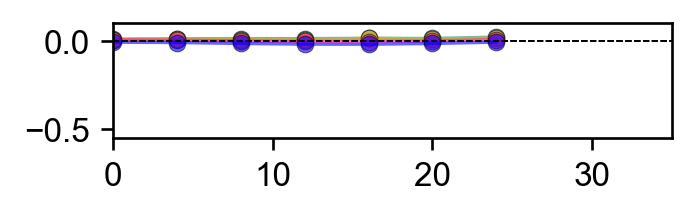

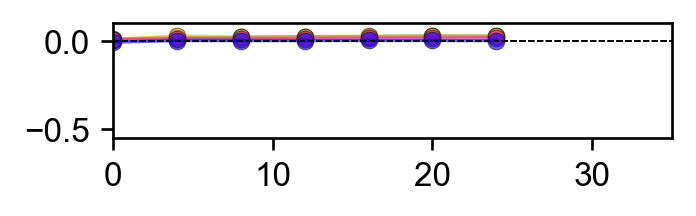

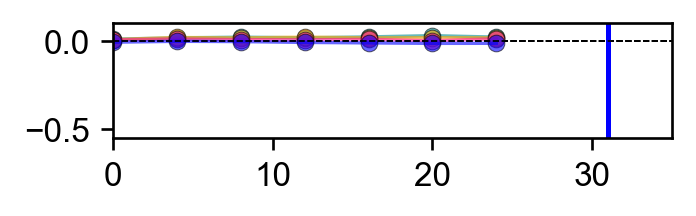

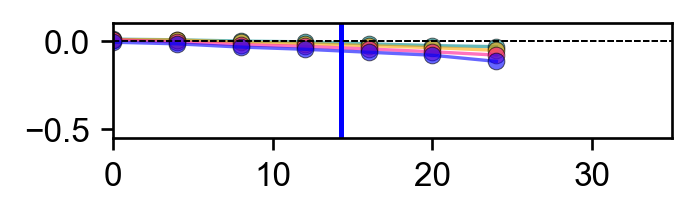

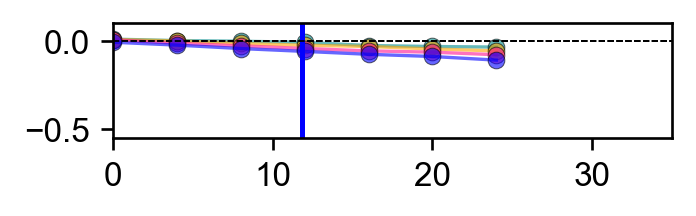

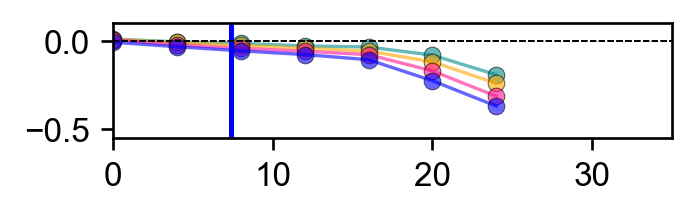

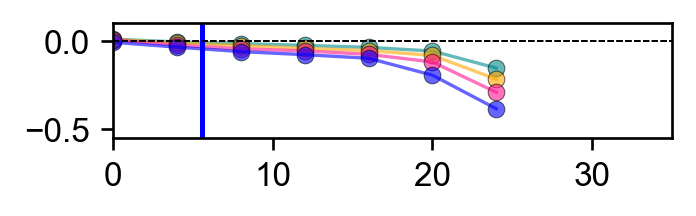

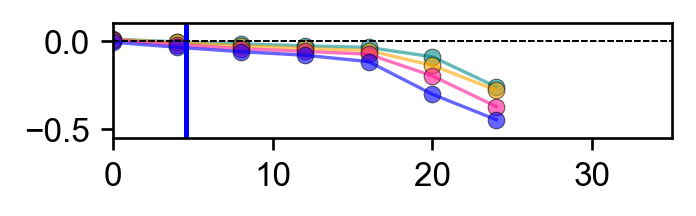

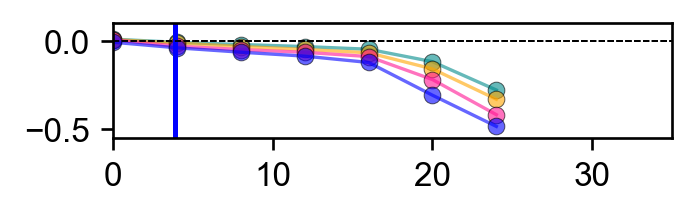

In [14]:
# flag that sets how big the actual figure is!
scalar = 0.8

# define grouping of solutes
PEGS = ['EG','PEG200', 'PEG400', 'PEG1500', 'PEG2000', 'PEG4000', 'PEG6000', 'PEG8000','PEG10000'] 
ind = np.arange(len(all_solvents_no_salt))


# define colours for each of those groups
COLOR_SETS = [["#FFEDEA", "#CD2200"],
              ["#D3D2D2", "#3B3B3B"],
              ["#A5FBFE", "#06E8F0"],
              ["#CDD1F7", "#061FF0"],
              ["#EDEAAD", "#F0E505"],
              ["#F39BF1", "#F30DEF"]]

ALL_COLORS = ['#008b8b', '#ffa500', '#ff1493', '#0000ff']

for s in PEGS:    

    figure(num=None, figsize=(3, 1), dpi=120, facecolor='w', edgecolor='k')
    idx = 0
    for protein in ['GS8', 'GS16', 'GS24', 'GS32']:

        # tmp here is chi values
        tmp_chi = all_data[protein][s].transpose()[1]
        tmp_conc = all_data[protein][s].transpose()[0]

        # get me the freakin overlap concentration in molar units
        cstar = PEG_CSTAR[s]
        csta_ww = convert_molality_to_ww(s, cstar)

        plt.plot(tmp_conc , tmp_chi,'-o',alpha=0.6, color=ALL_COLORS[idx], mec='k', mew='0.3', markersize=5, linewidth=1)
        plt.plot( [csta_ww, csta_ww], [-1, 1],'b-')
        plt.plot([0,35], [0,0],'--k',linewidth=0.5)
        plt.xlim([0,35])
        plt.ylim([-0.55,0.1])
        idx = idx + 1
        
    plt.tight_layout()
    plt.savefig('figures/FIG_S17/PGE_FIGURE_%s.pdf'%(s))
        
